# Demo script



Import and examine the version of the Azure ML SDK. This demo was created using the 0.1.65 version of the SDK.

In [1]:
import azureml.core
print("SDK Version: ", azureml.core.__version__)

SDK Version:  0.1.68


## BEFORE YOU BEGIN

1. If you want this notebook to run from start to finish without needing to enter your credentials, make sure that you run the Connect to Azure command from the Data menu above to make your Azure Credentials available to the scripts running in this notebook. **If you see a device login prompt, this almost always means that you forgot to run the Data/Connect to Azure command.**

This notebook takes ~25 minutes to run from start to finish.

## Azure ML Workspaces

The workspace is the top-level resource for the Azure Machine Learning service. It provides a centralized place to work with all the artifacts you create when using Azure Machine Learning Service.

The workspace keeps a list of compute targets that can be used to train your model. It also keeps a history of the training runs, including logs, metrics, output, and a snapshot of your scripts. This information is used to determine which training run produces the best model.

Models are registered with the workspace. A registered model and scoring scripts are used to create an image. The image can then be deployed into Azure Container Instances, Azure Kubernetes Service, or to a field-programmable gate array (FPGA) as a REST-based HTTP endpoint. It can also be deployed to an Azure IoT Edge device as a module.

This would be a good time to graphically explore the ```TechSummit``` workspace using Visual Studio Code and the Azure ML extension. You can easily see the different kinds of resources that are there. Note that the Visual Studio Code Azure ML extension makes it easy to work with Azure ML workspaces directly from the editor that you're using to create your code. All of the operations that you can do in Visual Studio Code, including examining experiments etc. can be also done _programmatically_ in Azure Notebooks using the AML SDK.

Before we can interact with a workspace, we first need to acquire a reference to it. Create or open the ```TechSummit``` Azure ML workspace. 

In [2]:
workspace_name = 'TechSummit'
experiment_name = 'TechSummitDemo'
simple_experiment_name = 'TechSummitDemoSimple'
hyperdrive_experiment_name = 'TechSummitHyperDriveDemo'
resource_group = 'juliademo'
compute_name = 'nc6cluster'
dataset_name = 'mnist'
training_script_filename = 'tf_mnist.py'

In [3]:
from azureml.core import Workspace

ws = Workspace.get(name=workspace_name, 
                   subscription_id='15ae9cb6-95c1-483d-a0e3-b1a1a3b06324', 
                   resource_group=resource_group) 
ws.name

'TechSummit'

Before we can submit jobs to the cluster that we saw earlier, we need to retrieve a reference to it. Note that the ```nc6cluster``` has already been created earlier in this demo. The ```ComputeTarget.create``` method can be called to either create or retrieve a reference to an existing cluster; it will not return an error if the cluster already exists.


In [4]:
cluster = ws.compute_targets()[compute_name]

## Running a simple experiment using our Azure Batch AI cluster

Let's begin by creating a new experiment called ```TechSummitDemo``` in our workspace, and running the ```tf_mnist.py``` file using it. An **Experiment** constructs a reproducible execution environment for running your model training scripts. It does so by creating a **Docker container** for the execution environment for the experiment. The Docker container is saved to the Azure Container Registry in your **Workspace**, ensuring that you will always be able to come back to reproduce the results of this experiment in the future.

Once the container is created, it must be downloaded onto each of the compute nodes on the cluster before the runs can begin. Note that this can take quite some time to complete the first time that you configure the Experiment. But once complete, you now can recreate the environment rapidly by re-running the experiment.

In [5]:
from azureml.core import Experiment

simple_experiment = Experiment(ws, simple_experiment_name)

### Run just one of the following two cells!

Run the first one if you want to show the experiment running. This experiment takes ~90s to run on the cluster.

Run the second cell if you want to pull data from a saved experimental run.

In [6]:
from azureml.train.dnn import TensorFlow

ds = ws.get_default_datastore()
mnist_data = ds.path(dataset_name)

script_params = {
    '--data-folder': mnist_data
}

estimator = TensorFlow(source_directory='.',
                       compute_target=cluster,
                       entry_script=training_script_filename,
                       script_params=script_params)

run = simple_experiment.submit(estimator)
run_id = run.id
run_id

'TechSummitDemoSimple_1540352490318'

In [6]:
run_id = 'TechSummitDemoSimple_1540338450989'

If we examine the ```run``` object, we can see a link to the Azure Portal that shows a summary of the run. If you don't see the Azure ML ```UserRun``` widget appearing below, you haven't installed the widget into your Jupyter Notebook instance. You will need to exit Jupyter, run the following two commands from the console that you started Jupyter from, and restart the notebook server.

```
jupyter nbextension install --py --user azureml.train.widgets
jupyter nbextension enable azureml.train.widgets --user --py```

In [7]:
from azureml.core import Run
from azureml.train.widgets import RunDetails

RunDetails(Run(simple_experiment, run_id)).show()

_UserRun(widget_settings={'childWidgetDisplay': 'popup'})

## Using HyperDrive to do hyper parameter optimization

Now that we have a model, the next step is to tune it for hyperdrive parameters. Start by retrieving a reference to our HyperDrive experiment.

In [8]:
experiment = ws.experiments()[experiment_name]

### Run just one of the following two cells!

Run the first one if you want to show the experiment running. This experiment takes ~12 minutes to run on the cluster.

Run the second cell if you want to pull data from a saved experimental run.

In [ ]:
from azureml.train.dnn import TensorFlow
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveRunConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import loguniform, uniform

ds = ws.get_default_datastore()
mnist_data = ds.path(dataset_name)

script_params={
    '--data-folder': mnist_data,
}

tf_estimator = TensorFlow(source_directory='.',
                          compute_target=cluster,
                          entry_script='tf_mnist.py',
                          script_params=script_params)

ps = RandomParameterSampling(
    {
        '--learning-rate': loguniform(-15, -3)
    }
)

early_termination_policy = BanditPolicy(slack_factor = 0.15, evaluation_interval=2)

hyperdrive_run_config = HyperDriveRunConfig(estimator = tf_estimator, 
                                            hyperparameter_sampling = ps, 
                                            policy = early_termination_policy,
                                            primary_metric_name = "final_acc",
                                            primary_metric_goal = PrimaryMetricGoal.MAXIMIZE,
                                            max_total_runs = 20,
                                            max_concurrent_runs = 5)

hd_run = experiment.submit(hyperdrive_run_config)
hd_run_id = hd_run.id
hd_run_id

In [9]:
hd_run_id = 'TechSummitDemo_1540317335250'

In [10]:
from azureml.core import Run
from azureml.train.widgets import RunDetails

RunDetails(Run(experiment, hd_run_id)).show()

_HyperDrive(widget_settings={'childWidgetDisplay': 'popup'})

## Deploying the best model

If you are pressed for time, you can just walk through the deployment code and skip to the next section, ```Testing our deployed model```.

Let's deploy the best run in the Hyperdrive tuning session, deploy the model to ACI and make a prediction using it. 
Note that the line below waits for the Hyperdrive run to complete, and the ```get_best_run_by_primary_metric()``` method is currently running very slowly. Be patient.

### Run just one of the following two cells!

Run the first one if you want to pull the best run from the currently running experiment. Note that this will block the notebook until the run is complete (~12 minutes).

Run the second cell if you want to pull data from a saved experimental run.

In [ ]:
hd_run.wait_for_completion()
best_run = hd_run.get_best_run_by_primary_metric()
best_run.id

In [ ]:
from azureml.core import Run

best_run_id = 'TechSummitDemo_1540317335250_2'
best_run = Run(experiment, best_run_id)

Register the model from the ```best_run``` with AML.

In [ ]:
model = best_run.register_model(model_name='tf-dnn-mnist', model_path='outputs/model')

Below is a file that contains the model scoring code. It loads the model that was generated from the earlier training session into Tensorflow, and implements a ```run``` method that invokes the model to make a prediction using data that is passed in from a Web Service wrapper that was created by the AML Service.

The magic at the top of the cell simply takes the contents of the cell and writes it out to a local file called ```score.py```.

In [ ]:
%%writefile score.py
import json
import numpy as np
import os
import tensorflow as tf

from azureml.core.model import Model

def init():
    global X, output, sess
    tf.reset_default_graph()
    model_root = Model.get_model_path('tf-dnn-mnist')
    saver = tf.train.import_meta_graph(os.path.join(model_root, 'mnist-tf.model.meta'))
    X = tf.get_default_graph().get_tensor_by_name("network/X:0")
    output = tf.get_default_graph().get_tensor_by_name("network/output/MatMul:0")
    
    sess = tf.Session()
    saver.restore(sess, os.path.join(model_root, 'mnist-tf.model'))

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    out = output.eval(session = sess, feed_dict = {X: data})
    y_hat = np.argmax(out, axis = 1)
    return json.dumps(y_hat.tolist())

The ```score.py``` file is run in an execution environment that contains the libraries that are required. The cell below constructs a new execution environment specification that includes both the Tensorflow runtime, as well as the ```numpy``` libary.

In [ ]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('numpy')
cd.add_tensorflow_conda_package()
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

The runtime environment defined by the ```myenv.yml``` file is installed into a Docker container image that is created by the AML service. We also tell the container image what language runtime to use, and what file to run in the image (```score.py```).

In [ ]:
from azureml.core.image import ContainerImage

imgconfig = ContainerImage.image_configuration(execution_script="score.py", 
                                               runtime="python", 
                                               conda_file="myenv.yml")

That Docker container is serialized into an Azure Container Registry instance that is part of the resource group for the AML Workspace that we are using. There is also an Azure Container Instances service that is part of the resource group, and it is used to run the container that we provision below. 

In [ ]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'name':'mnist', 'framework': 'TensorFlow DNN'},
                                               description='Tensorflow DNN on MNIST from HyperDrive')

Deploy the container onto ACI, and start it running. It takes ~9 minutes to complete this operation.

In [ ]:
%%time
from azureml.core.webservice import Webservice

service = Webservice.deploy_from_model(workspace=ws,
                                       name='tf-mnist-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=imgconfig)

service.wait_for_deployment(show_output=True)

Examine the URI for the scoring service. This will be used below.

In [ ]:
service.scoring_uri

## Testing our deployed model

Assign the URI cached above in the notebook to a local variable. This is done for the cases where we don't have enough time to wait for the service to deploy, so we can just re-use 

In [11]:
service_uri = 'http://40.76.74.244:80/score'

Download the training and the sample data for the mnist dataset. In the future, we should just keep the training dataset in a local directory in the project vs. taking the bandwidth to download the full training dataset. We're just using the test dataset to test our model's inferencing capabilities.

In [12]:
import gzip
import numpy as np
import struct

def read_idx(filename):
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
training_dataset = 't10k-images-idx3-ubyte.gz'
training_labels = 't10k-labels-idx1-ubyte.gz'
X_test = read_idx(training_dataset).reshape(10000, 784)
y_test = read_idx(training_labels)

Make a request to the web service that we just deployed at the ```service.scoring_uri```. The code below will render the digit that is being sent to our model, as well as showing what the original test label was, and the prediction that was returned from the model.

POST to url http://40.76.74.244:80/score
label: 1
prediction: "[1]"


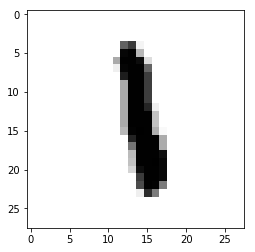

In [13]:
%matplotlib inline

import requests
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

resp = requests.post(service_uri, input_data, headers=headers)

print("POST to url", service_uri)
print("label:", y_test[random_index])
print("prediction:", resp.text)

plt.imshow(X_test[random_index].reshape(28, 28), cmap=plt.cm.Greys)